In [14]:
import numpy as np
import operator
import random
import time
import matplotlib.pyplot as plt
T = 2000

In [15]:
class GA:
	"""
	Find the minium of the func: x1^2 + x2^3 +... + x50^2
	where xi in range(-10, 10)
	"""
	def __init__(self, num_of_var, pop_size, constraints, mutated_chance, selection_percent, T, alpha):
		self.num_of_var = num_of_var
		self.pop_size = pop_size
		self.constraints = constraints
		self.mutated_chance = mutated_chance
		self.selection_percent = selection_percent
		self.pop = self.generateFirstPop(constraints)
		self.prob = []
		self.T = T
		self.alpha = alpha

	def generateFirstPop(self, constraints):
		pop = np.array([])
		pop = np.append(pop, np.random.randint(constraints[0], constraints[1], self.num_of_var*self.pop_size))
		pop = pop.reshape(self.pop_size, self.num_of_var)
		return pop.tolist()

	def fitness(self, solution):
		res = 0
		for i in range(self.num_of_var):
			if (i%2) == 0:
				res += solution[i]**2
			else:
				res += solution[i]**3
		return res

	def evaluation(self):
		fit = np.array([self.fitness(solution) for solution in self.pop])
		fit = 1/np.exp((fit - fit.min()  + 1 )/self.T)
		prob = np.array([fit/fit.sum()])
		prob = prob.reshape(self.pop_size)

		self.prob = prob.tolist()

	def BoltzmannSel(self):
		r = random.random()
		i = 0
		prob = np.asarray(self.prob)
		prob = prob/(prob.sum())
		self.prob = prob.tolist()
		sum = self.prob[i]
		while sum < r:
			i += 1
			sum += self.prob[i]
		self.prob[i] = 0
		return i

	def selection(self):
		selected_parents_index = []
		unselected_parents_index = []
		# Slow need fix
		for i in range(int(self.pop_size*self.selection_percent)):
			temp = self.BoltzmannSel()
			count = 0
			while temp in selected_parents_index:
				count += 1
				if count > 100:
					exit()
				print(count)
				temp = self.BoltzmannSel()
			# print("out")
			selected_parents_index.append(temp)

		for j in range(self.pop_size):
			if j not in selected_parents_index:
				unselected_parents_index.append(j)
		return selected_parents_index, unselected_parents_index

	def davisOrderOneChild(self, parent1, parent2):
		permutation1 = np.random.permutation(self.num_of_var)
		permutation2 = np.random.permutation(self.num_of_var)
		cross_point = np.random.randint(self.constraints[0], self.constraints[1], 2)
		start_point = cross_point.min()
		end_point = cross_point.max()

		p1_segment = permutation1[start_point:end_point]
		p1_gens = []
		for i in p1_segment:
			p1_gens.append(parent1[i])
		C = np.zeros(self.num_of_var)
		C[start_point: end_point] = p1_gens
		i = end_point
		for j in range(end_point, self.num_of_var + end_point):
			if permutation2[j%self.num_of_var] not in p1_segment:
				C[i%self.num_of_var] = parent2[permutation2[j%self.num_of_var]]
				i += 1
			else:
				j += 1
		return C

	def multiCrossOver(self, parent1, parent2):
		p1, p2 = random.sample(range(self.num_of_var), 2)
		start = min(p1, p2)
		end = max(p1, p2)
		child = []
		child = parent1[:start] + parent2[start:end] + parent1[end:]
		return child


	def crossOver(self):
		new_pop = []
		selected_parents_index, unselected_parents_index = self.selection()
		selection_num = len(selected_parents_index)

		for i in range(len(selected_parents_index) - 1):
			j = selected_parents_index[i+1]
			child1 = self.davisOrderOneChild(self.pop[i], self.pop[j])
			child2 = self.davisOrderOneChild(self.pop[j], self.pop[i])
			new_pop.append(child1)
			new_pop.append(child2)

		new_pop = random.choices(new_pop, k = selection_num)
		for i in selected_parents_index:
			new_pop.append(self.pop[i])
		self.pop = new_pop

	# MUTATION
	def randomResetting(self):
		for solution in self.pop:
			r = random.random()
			if r < self.mutated_chance:
				gen = random.randint(0, self.num_of_var - 1)
				solution[gen] = random.randint(self.constraints[0], self.constraints[1])

	def SwapMutation(self):
		for solution in self.pop:
			r = random.random()
			if r < self.mutated_chance:
				gen1, gen2 = random.sample(range(self.num_of_var), 2)
				temp = solution[gen1]
				solution[gen1] = solution[gen2]
				solution[gen2] = temp

	def ScrambleMutation(self):
		for solution in self.pop:
			r = random.random()
			if r < self.mutated_chance:
				fi_point, se_point = random.sample(range(self.num_of_var), 2)
				low = min(fi_point, se_point)
				high = max(fi_point, se_point)
				permuted_segment = np.random.permutation(solution[low:high])
				solution[low: high] = permuted_segment

	def InversionMutation(self):
		for solution in self.pop:
			r = random.random()
			if r < self.mutated_chance:
				fi_point, se_point = random.sample(range(self.num_of_var), 2)
				low = min(fi_point, se_point)
				high = max(fi_point, se_point)
				permuted_segment = np.flip(solution[low:high], axis =0)
				solution[low: high] = permuted_segment
				
	def objectFunc(self):
		res = []
		for solution in self.pop:
			sol = np.asarray(solution)
			sol_even = np.take(sol, np.arange(0, self.num_of_var, 2))
			sol_odd = np.take(sol, np.arange(1, self.num_of_var, 2))
			temp = (sol_even**2).sum() + (sol_odd**3).sum()
			res.append(temp)
		min_res = min(res)
		min_index = res.index(min(res))

		# print("solution has min: ", self.pop[min_index])
		# print("Min of res: ", min_res)
		return min_res

	def run(self, mutation):
		gen = 0
		all_res = []
		while (gen < 2000):
			# start = time.clock()
			if self.T > 100:
				self.T -= self.alpha
			# start = time.clock()
			min_res = self.objectFunc()
			all_res.append(min_res)
			# print("objectFunc time:", time.clock() - start)
			# start = time.clock()
			self.evaluation()
			# print("evaluation:", time.clock() - start)
			# start = time.clock()
			self.crossOver()
			# print("crossOver:", time.clock() - start)
			# start = time.clock()
			if mutation == "BFM":
				self.randomResetting()
			elif mutation == "SM":
				self.SwapMutation()
			elif mutation == "ScM":
				self.ScrambleMutation()
			else:
				self.InversionMutation()
			# print("randomResetting:", time.clock() - start)
# 			print("gen = ", gen, "T = ", self.T,"Min_reach: ", min_res, "pop_size", len(self.pop))
			gen += 1
			# print("Time per iteration: ", time.clock() - start)
		return all_res, gen, 

In [16]:
test = GA(num_of_var = 50, pop_size = 200, constraints = [-10, 10], mutated_chance = 0.2, selection_percent = 0.5, T = 2000, alpha = 15)

In [17]:
start = time.clock()
SM_res, gen1 = test.run("SM")
SM_time = time.clock() - start

In [18]:
start = time.clock()
test.T = T
test.pop = test.generateFirstPop([-10, 10])
BFM_res, gen2 = test.run("BFM")
BFM_time = time.clock() - start

In [19]:
start = time.clock()
test.T = T
test.pop = test.generateFirstPop([-10, 10])
ScM_res, gen3 = test.run("ScM")
ScM_time = time.clock() - start

In [20]:
start = time.clock()
test.T = T
test.pop = test.generateFirstPop([-10, 10])
IM_res, gen4 = test.run("IM")
IM_time = time.clock() - start

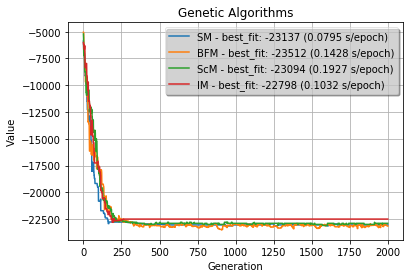

In [21]:
X = list(range(0, gen1))

ax = plt.subplot(111)
plt.title("Genetic Algorithms" )
plt.plot(X, SM_res, label = "SM - best_fit: %d (%.4lf s/epoch)" %(min(SM_res), SM_time/gen1))
plt.plot(X, BFM_res, label = "BFM - best_fit: %d (%.4lf s/epoch)" %(min(BFM_res), BFM_time/gen2))
plt.plot(X, ScM_res, label = "ScM - best_fit: %d (%.4lf s/epoch)" %(min(ScM_res), ScM_time/gen3))
plt.plot(X, IM_res, label = "IM - best_fit: %d (%.4lf s/epoch)" %(min(IM_res), IM_time/gen4))
plt.grid(True)

leg = plt.legend(loc = 'upper right', ncol = 1,  shadow = True, fancybox = True)
leg.get_frame().set_alpha(0.5)

plt.xlabel("Generation")
plt.ylabel("Value")
plt.show()

# _It seems that using OX1 (permutation-base method) doesn't work well with this problem_